In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

**Warning** *this is an extremely technical blog post (even for me) but I think that it's an interesting experiment so I thought I would post it anyways!*

The *Kepler* Mission has been a great success story for open science. The recent data releases have been on a fast and regular schedule and the data products are sometimes made public before the science office publishes their papers. Therefore, when the most recent installment in the "rate of Earths" saga—a discussion [close to my heart](http://arxiv.org/abs/1406.3020)—hit the ArXiv as [Burke et al. (2015)](http://arxiv.org/abs/1506.04175), I decided to see if I could reproduce their results by following the steps described in their paper. Crazy, right?

In this blog post, I'll go through the steps to reproduce most of their key results as an experiment in *Open Science*. [*Spoiler alert: I dont get exactly the same results but I do come to the same conclusions...*]

It's also worth noting that Burke also posted code and results to supplement the paper: [christopherburke/KeplerPORTs](https://github.com/christopherburke/KeplerPORTs).


## The science case

While the point of this post isn't to discuss the physical implications of this result, it is worth taking a moment to motivate this experiment. One of the key areas of research in exoplanets is (what I like to call) *population inference*; determining the underlying occurrence rate and distribution of exoplanets and their physical properties. This is interesting as a data science problem because we now have large catalogs of exoplanet discoveries and characterizations and it's interesting scientifically because it is the best shot we have of connecting exoplanet observations to theories of the formation and evolution of exoplanet systems. It also places a constraint on the frequency of planets like Earth and planetary systems like our Solar system (Are we alone? and all that...).

There has been a huge amount of research in this field but [Burke et al. (2015)](http://arxiv.org/abs/1506.04175) present (arguably) the most careful treatment of the systematic effects based on a characterization of the official *Kepler* pipeline. Even before submission, the data products describing this characterization were all publicly available on the [Exoplanet Archive](http://exoplanetarchive.ipac.caltech.edu/).


## The problem

The basic data analysis question that we're trying to answer here is: given an incomplete catalog of planet parameters (smaller planets on longer periods are harder to find), what can we say about the underlying distribution of properties? For this model, we'll use the Poisson process likelihood to compute the probability of a set of measurements (e.g. orbital period, planet radius, etc.) $w_k = (P_k,\,R_k)$, given a parametric model for the underlying "occurrence rate" $\Gamma_\theta(w)$

$$p(\{w_k\}\,|\,\theta) = \exp \left(\int Q(w)\,\Gamma_\theta(w)\,\mathrm{d}w\right) \, \prod_{k=1}^K Q(w_k)\,\Gamma_\theta(w_k)$$

where $Q(w)$ is an estimate of the (mean) detection efficiency (or completeness) as a function of the parameters $w$. Then, we just need to optimize for $\theta$ or choose a prior $p(\theta)$ and sample using MCMC. Like Burke et al., we'll build our model in orbital period (in days) and planet radius (in Earth radii) and use a product of independent power laws in the two dimensions for $\Gamma_\theta (w) = \Gamma_\theta (P)\,\Gamma_\theta (R)$.


## The data

To start, let's download (and cache) the dataset from the Exoplanet Archive. Don't worry about the details of these functions but what they do is download the csv tables (`q1_q16_stellar` and `q1_q16_koi`) and save them as a pandas block.

In [2]:
from __future__ import division, print_function
import os
import requests
import pandas as pd
from cStringIO import StringIO

def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

Now we will make the cuts on the stellar sample to select the G and K dwarfs:

* $4200\,K \le T_\mathrm{eff} \le 6100\,K$,
* $R_\star \le 1.15\,R_\odot$,
* $T_\mathrm{obs} > 2\,\mathrm{yr}$,
* $f_\mathrm{duty} > 0.6$, and
* $\mathrm{robCDPP7.5} \le 1000\,\mathrm{ppm}$.

In [3]:
import numpy as np

stlr = get_catalog(" q1_q17_dr24_stellar")

# Select and K dwarfs.
m = (3900 <= stlr.teff) & (stlr.teff <= 5300)
#m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dutycycle*stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.33
#m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 40685 targets after cuts


After applying these same cuts to a pre-release version of this catalog, Burke et al. found 91,567 targets.

[*Using the machine readable version of their Table 1, I tried to work out the reason for this difference and I couldn't reverse engineer any cause. Some of the targets missing from our catalog are just artificially fixed at Solar values so they seem reasonable to skip. This effect explains about half the difference between the results.*]

We can now make a plot of the HR diagram of these sources to reproduce Figure 3 from Burke et al.:

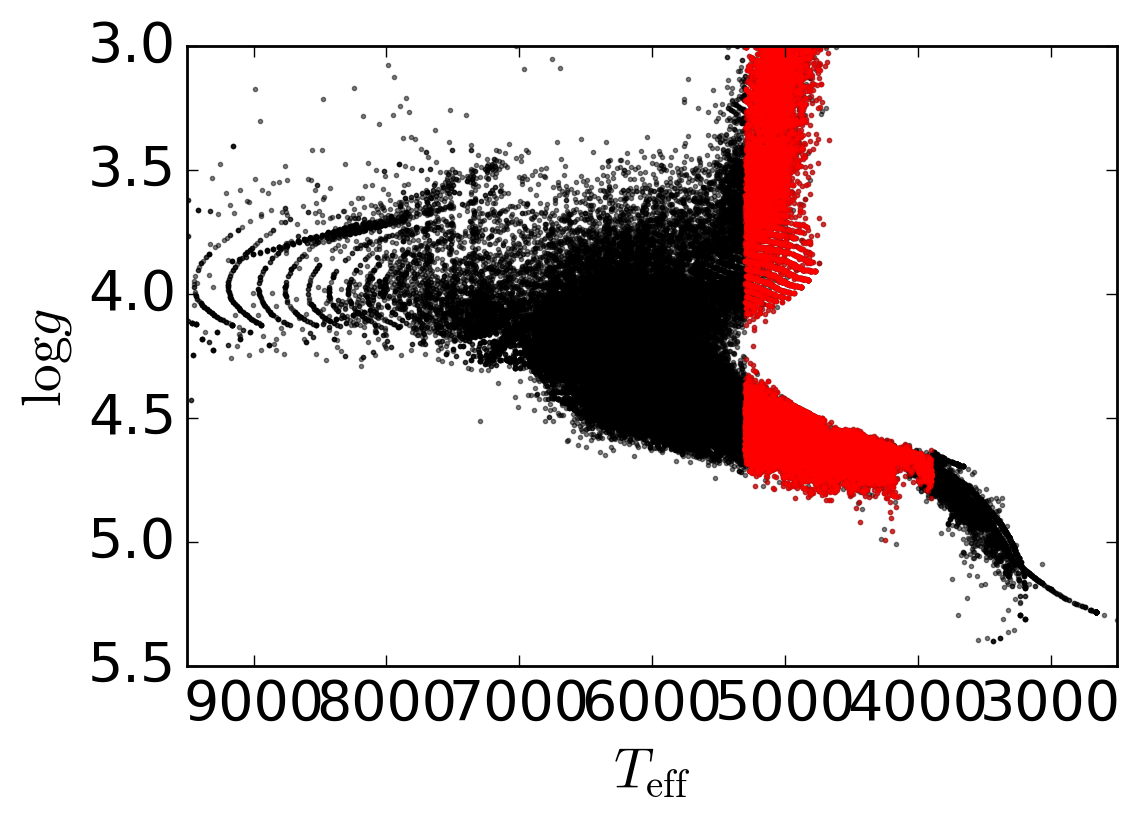

In [4]:
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");

Next up, let's make the cuts on the KOI list:

* disposition from the Q1-Q16 pipeline run: `CANDIDATE`,
* $50\,\mathrm{day} \le P \le 300\,\mathrm{day}$, and
* $0.75\,R_\oplus \le R \le 2.5\,R_\oplus$.

In [5]:
kois = get_catalog(" q1_q17_dr24_koi")

period_rng = (20, 300)
rp_rng = (0.75, 2.5)
#period_rng = (20, 40)
#rp_rng = (1.5, 2.3)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])
m &= kois.koi_max_mult_ev > 15
kois = pd.DataFrame(kois[m])

xx = kois.koi_max_mult_ev

print(xx)

print("Selected {0} KOIs after cuts".format(len(kois)))

19       19.501413
54       17.438600
71       17.906500
78       20.258747
87       19.653711
158      34.544308
213      35.427240
214      40.415380
223      29.052834
232      22.751736
280      53.885800
282      23.330261
283      35.074116
496      16.150210
523      33.313060
591      28.493334
659      37.909855
755      21.353193
759      15.984361
761      17.513052
785      20.053146
812      15.592409
817      15.004909
823      19.989270
824      16.953766
858      20.042608
860      16.920662
870      22.232930
905      19.391030
932      15.428210
           ...    
1016     21.431492
1029     39.895190
1034     16.435070
1045     38.194912
1061     18.905336
1062     21.090843
1089     16.452473
1093     29.168392
1094     27.169357
1095     32.315575
1105     40.684586
1108     38.613940
1124     34.818535
1145     20.476190
1156     23.657904
1170     43.459667
1176     53.310120
1186     27.961275
1187     19.734297
1203     18.602000
1223     25.711077
1302     18.

Burke et al. find 156 KOIs instead of our 154 again because of their pre-release version of the catalog and changing dispositions. As we'll see, this doesn't have a huge effect on the results even though there's some risk of being dominated by small number statistics.

Now, let's plot the distribution of measured physical parameters in this catalog of KOIs. Unlike most versions of this plot, here we'll include the error bars on the radii as a reminder that many of the radii are very poorly constrained!

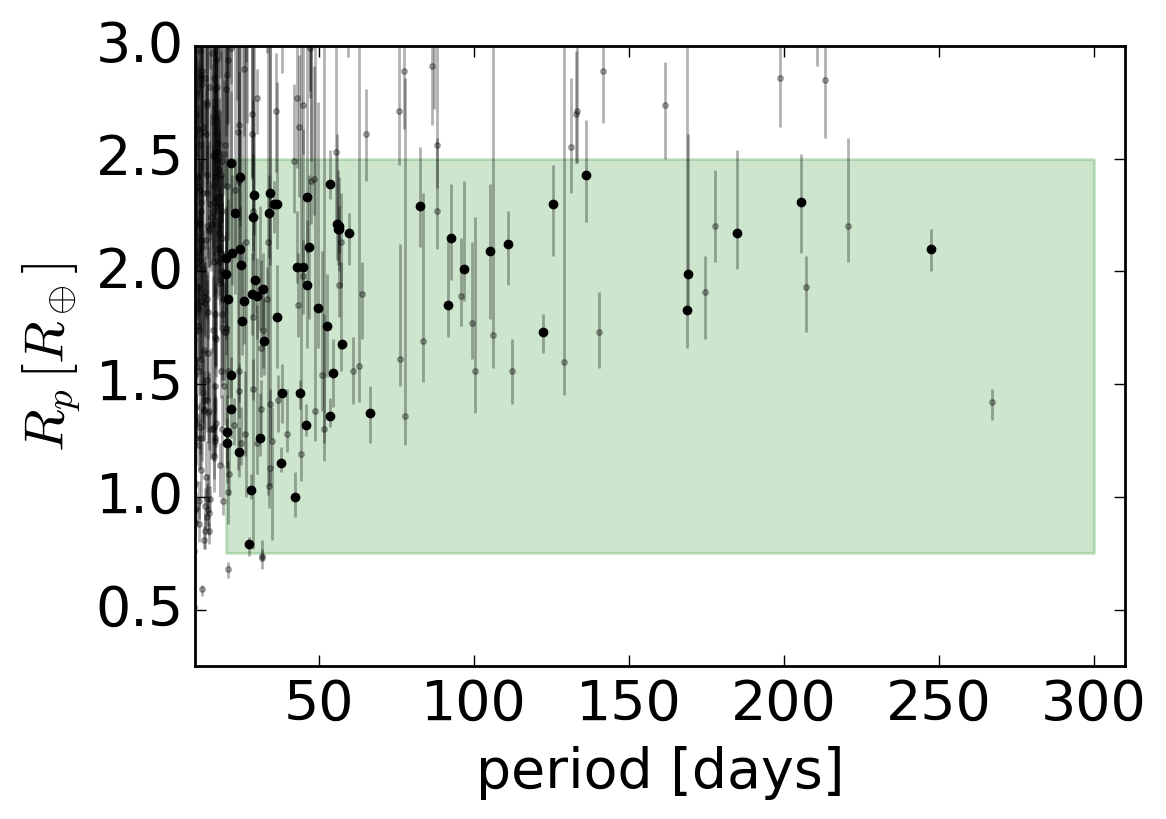

In [6]:
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(period_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="g", alpha=0.2)
pl.xlim(period_rng + 10 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

## The detection efficiency model

For this problem of population inference, an important ingredient is a detailed model of the efficiency with which the transit search pipeline detects transit signals. Burke et al. implement an analytic model for the detection efficiency that has been calibrated using simulations in a (submitted but unavailable) paper by Jessie Christiansen. The details of this model are given in the Burke et al. paper so I'll just go ahead and implement it and if you're interested, check out [the paper](http://arxiv.org/abs/1506.04175).

In [7]:
from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 1.0* delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
#pgam = gamma(4.65, loc=0., scale=0.98)
pgam = gamma(103.0113, loc=0., scale=0.10583)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return 0.78442*pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

Using this model, lets reproduce Figure 1 from the Burke paper. If you closely compare the figures, you'll find that they're not quite the same but the one in the paper was generated with an older (incomplete) version of the code (Burke, priv. comm.) and the model used is actually the same as this one so we'll roll with it!

In [71]:
# Choose the star.
star = stlr[stlr.kepid == 10593626].iloc[0]

# Compute the completeness map on a grid.
period = np.linspace(10, 700, 500)
rp = np.linspace(0.5, 2.5, 421)
X, Y = np.meshgrid(period, rp, indexing="ij")
Z = get_completeness(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure.
c = pl.contour(X, Y, Z, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.2f") 
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC10593626");

IndexError: index 0 is out of bounds for axis 0 with size 0

In practice, the only detection efficiency function that enters our analysis is *integrated across the stellar sample*. In fact, the function $Q(w)$ needs to be integrated (marginalized) over *all the parameters that affect it but aren't of interest*, for example, [we should include eccentricity](http://arxiv.org/abs/1408.1393). For now, following Burke et al., we'll ignore eccentricity and integrate only over the stellar parameters. This cell takes a minute or two to run because it must loop over every star in the sample and compute the completeness on a grid.

In [8]:
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)

In the target range, here is the completeness function (including the geometric transit probability):

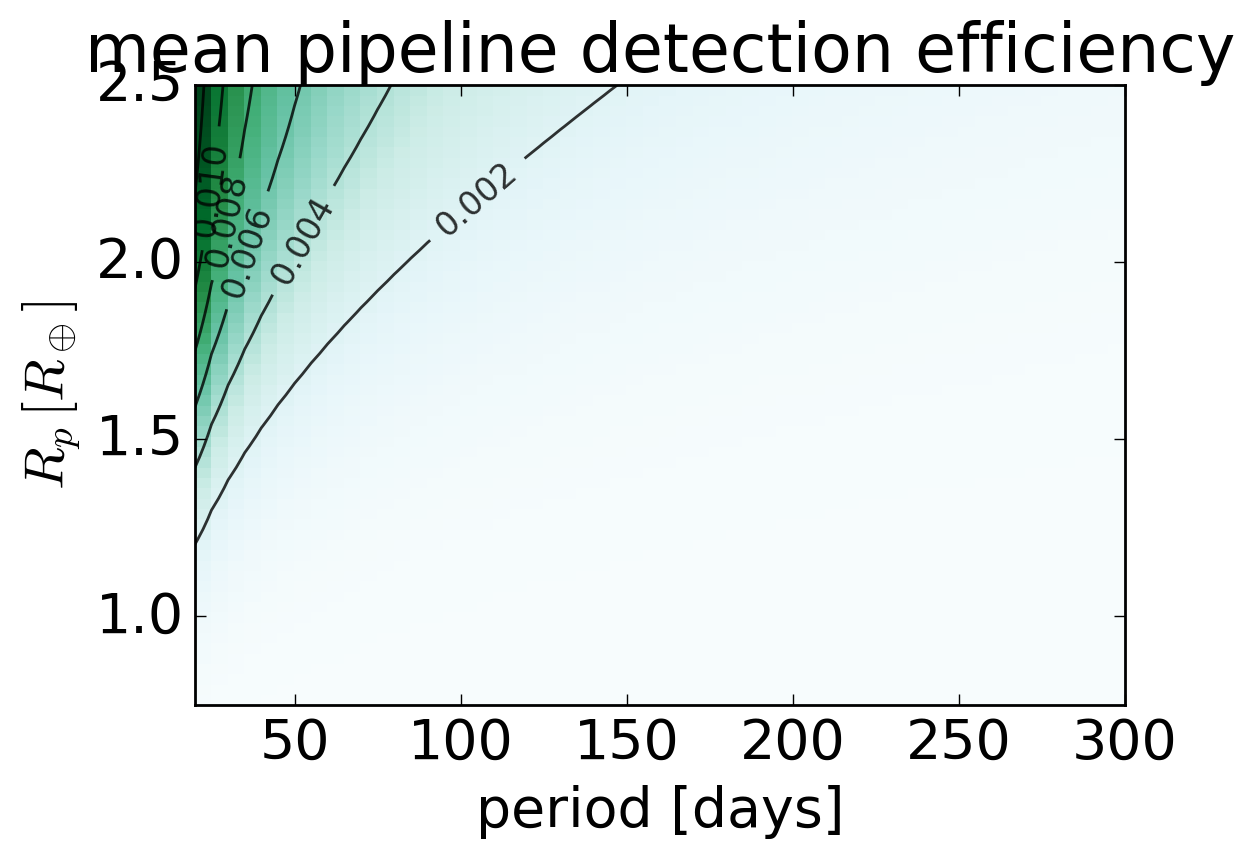

In [9]:
pl.pcolor(period_grid, rp_grid, comp, cmap="BuGn")
c = pl.contour(period_grid, rp_grid, comp / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("period [days]")
pl.ylabel("$R_p \, [R_\oplus]$");

## Population inference

Now that we have our sample and our completeness model, we need to specify the underlying population model. Like Burke et al., I've found that the data don't support a broken power law in planet radius so let's just model the population as the product of indpendent power laws in $P$ and $R_p$.

In [10]:
# A double power law model for the population.
def population_model(theta, period, rp):
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp),
                         (period_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

To start, let's find the maximum likelihood solution for the population parameters by minimizing the negative log-likelihood.

In [11]:
from scipy.optimize import minimize
theta_0 = np.array([np.log(0.75), -0.53218, -1.5])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)

      fun: 434.91307909699265
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.54747351e-05,  -2.84217094e-05,   0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 9
   status: 0
  success: True
        x: array([ 0.63916261, -0.63342394, -1.82594636])


...and plot it:

[ 1.22521765]


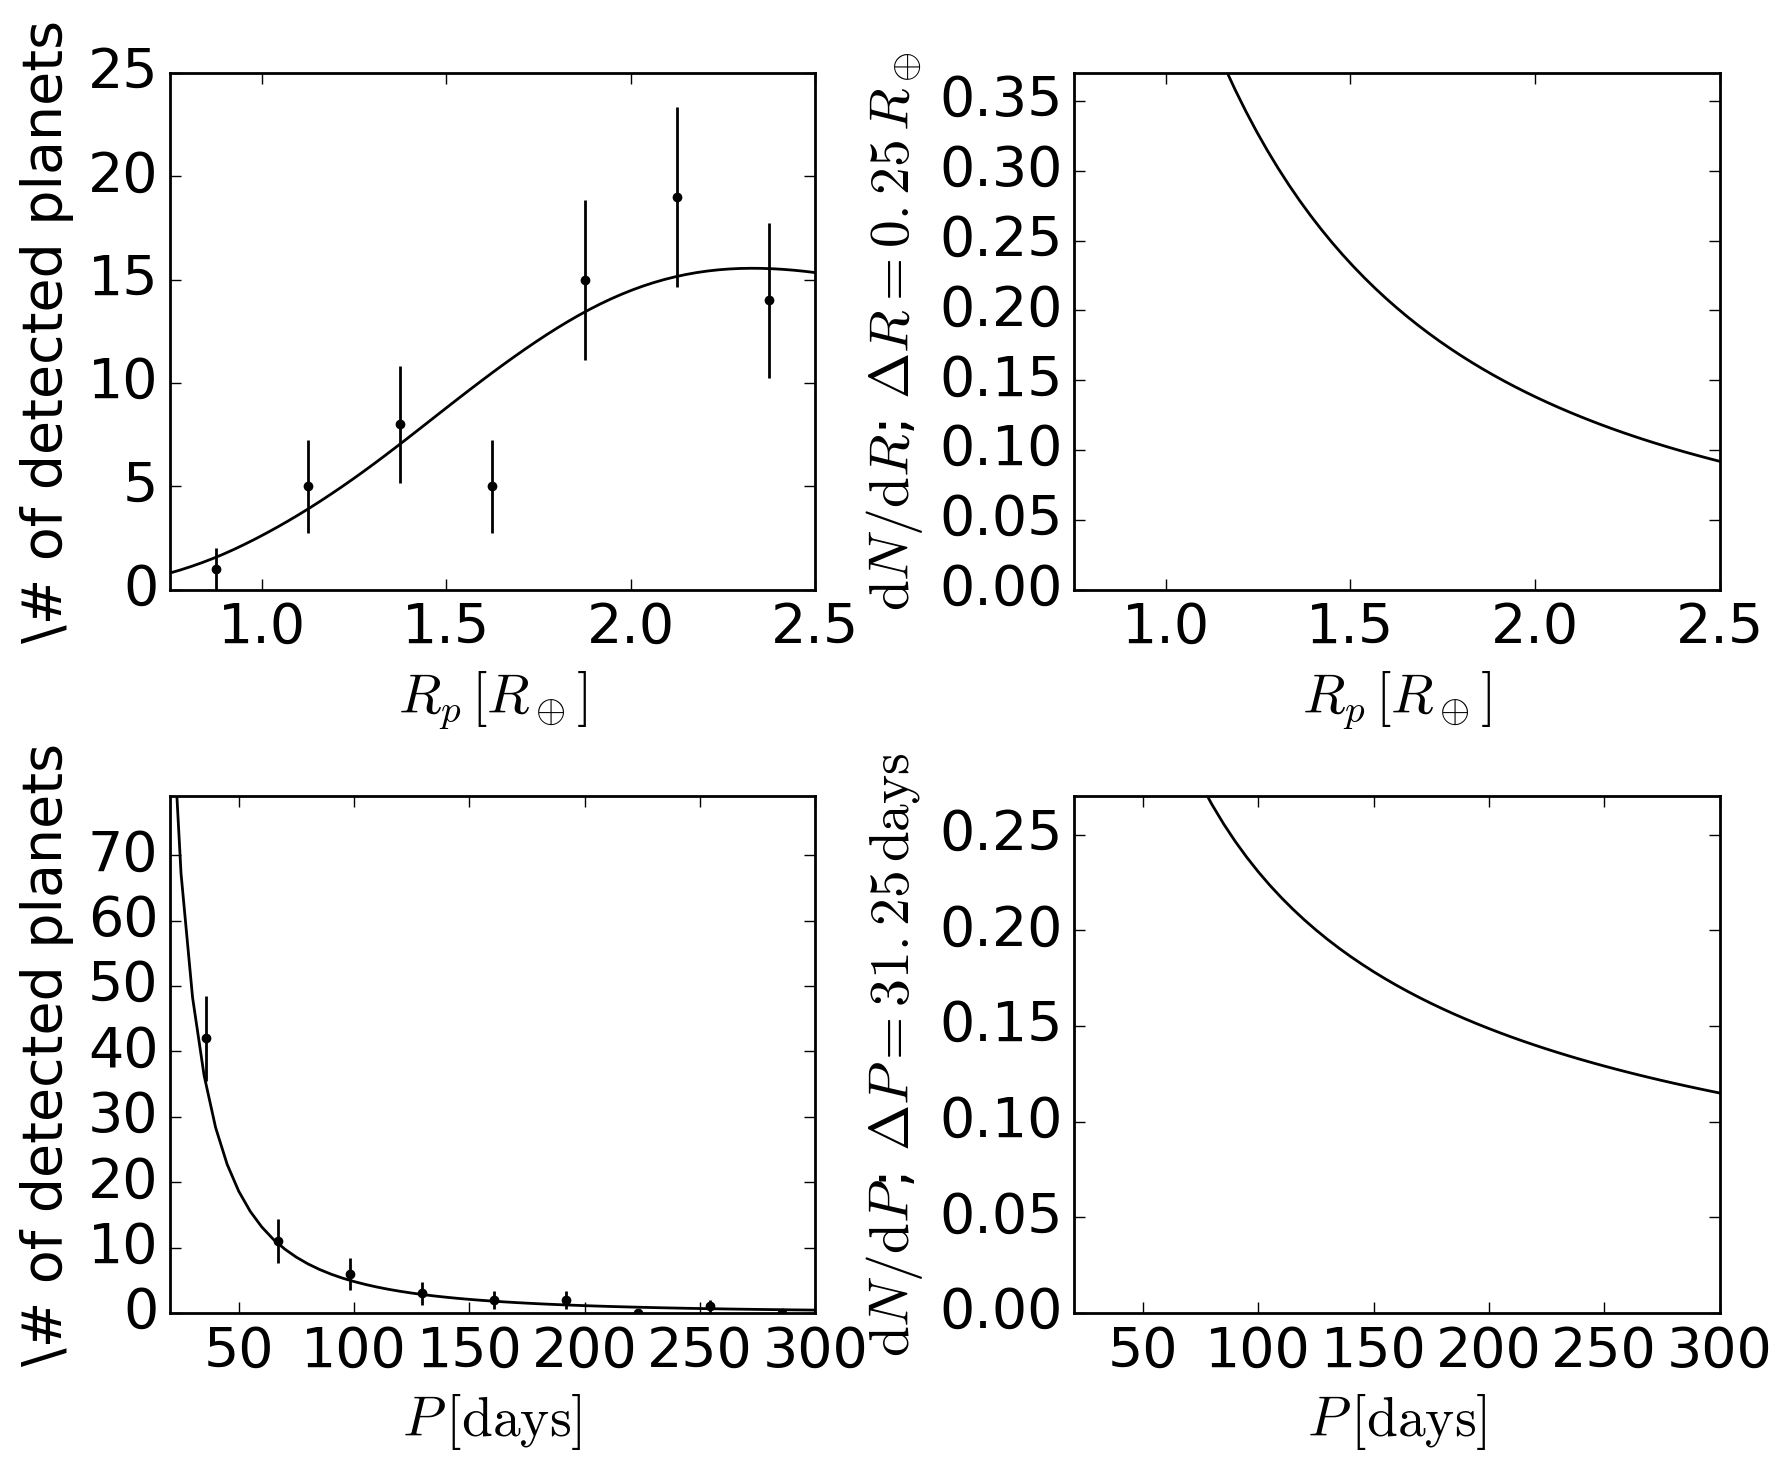

In [12]:
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, period_grid, rp_grid)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * comp[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * comp[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
    
    return gamma_earth

print(plot_results(r.x));

Finally, let's sample from the posterior probability for the population parameters using [emcee](http://dfm.io/emcee).

In [13]:
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)

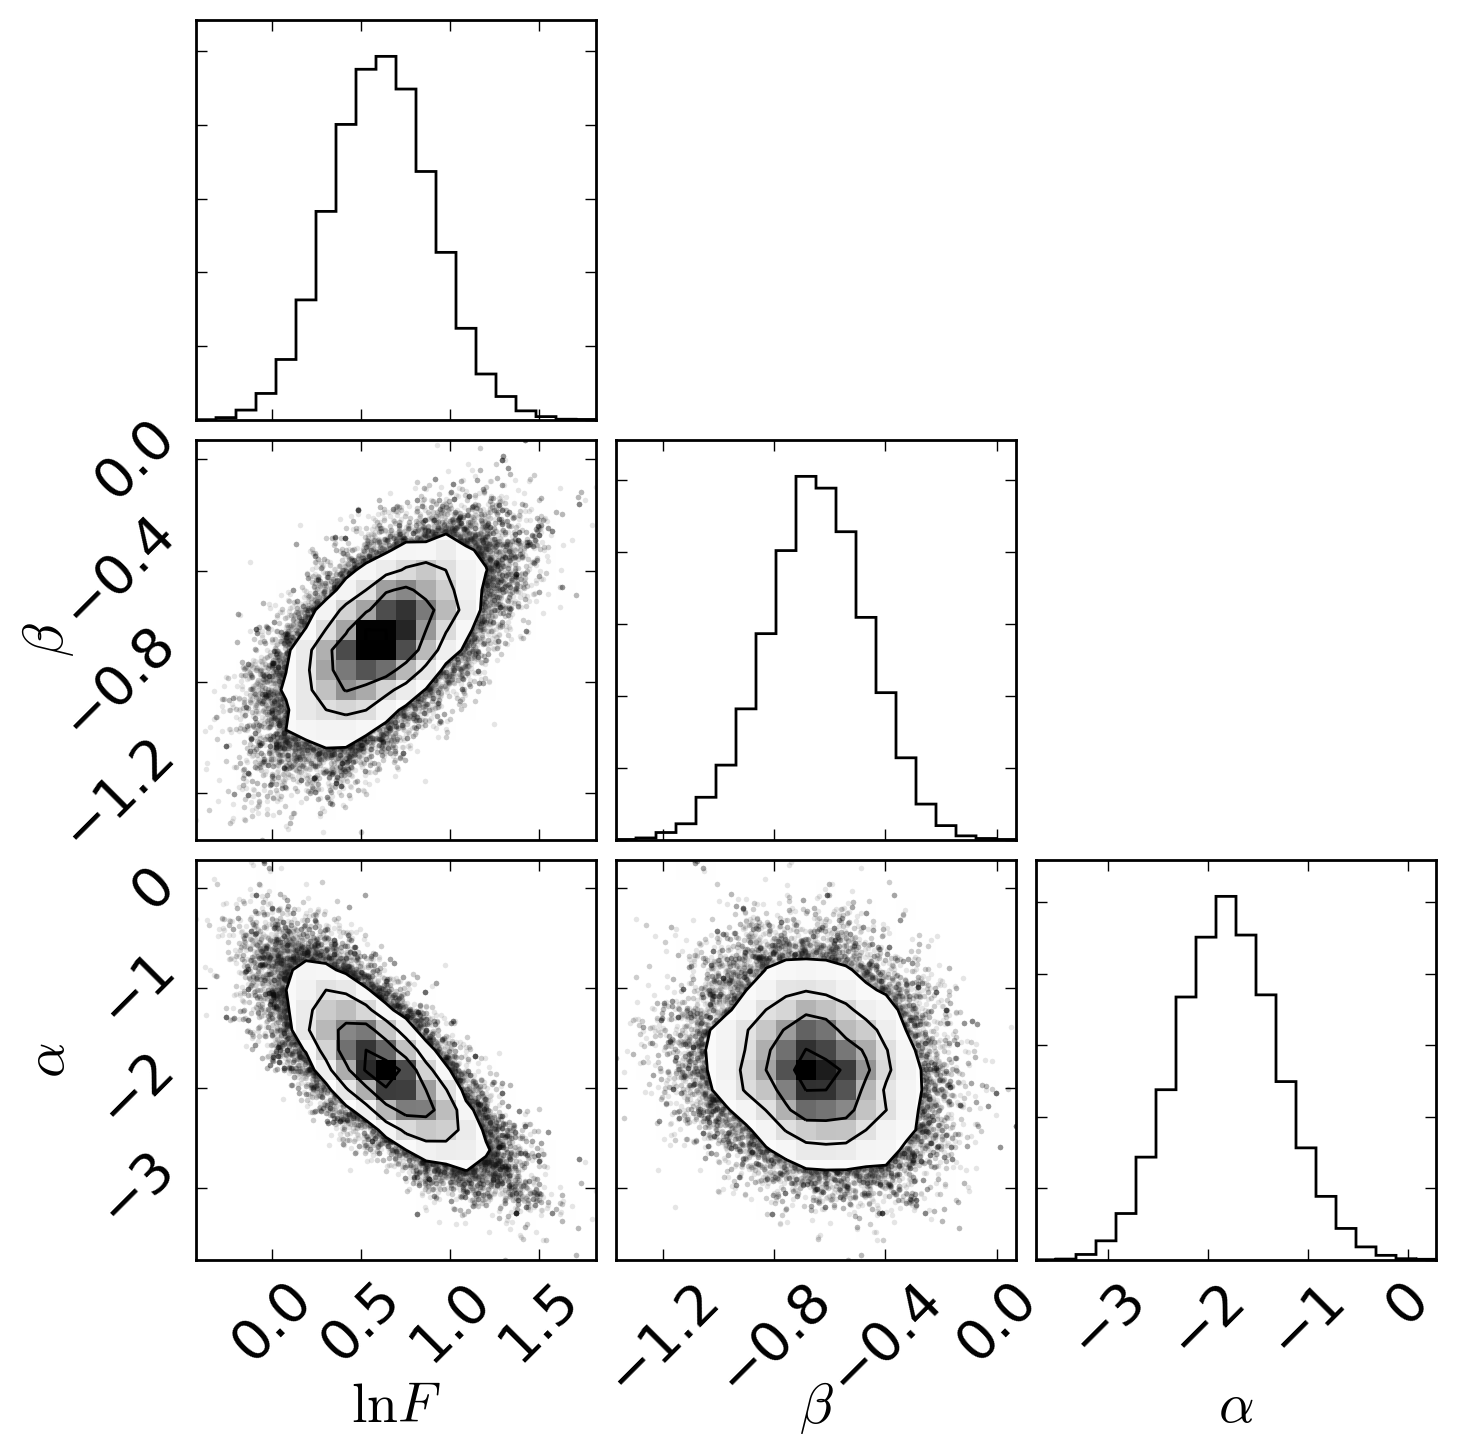

In [14]:
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);

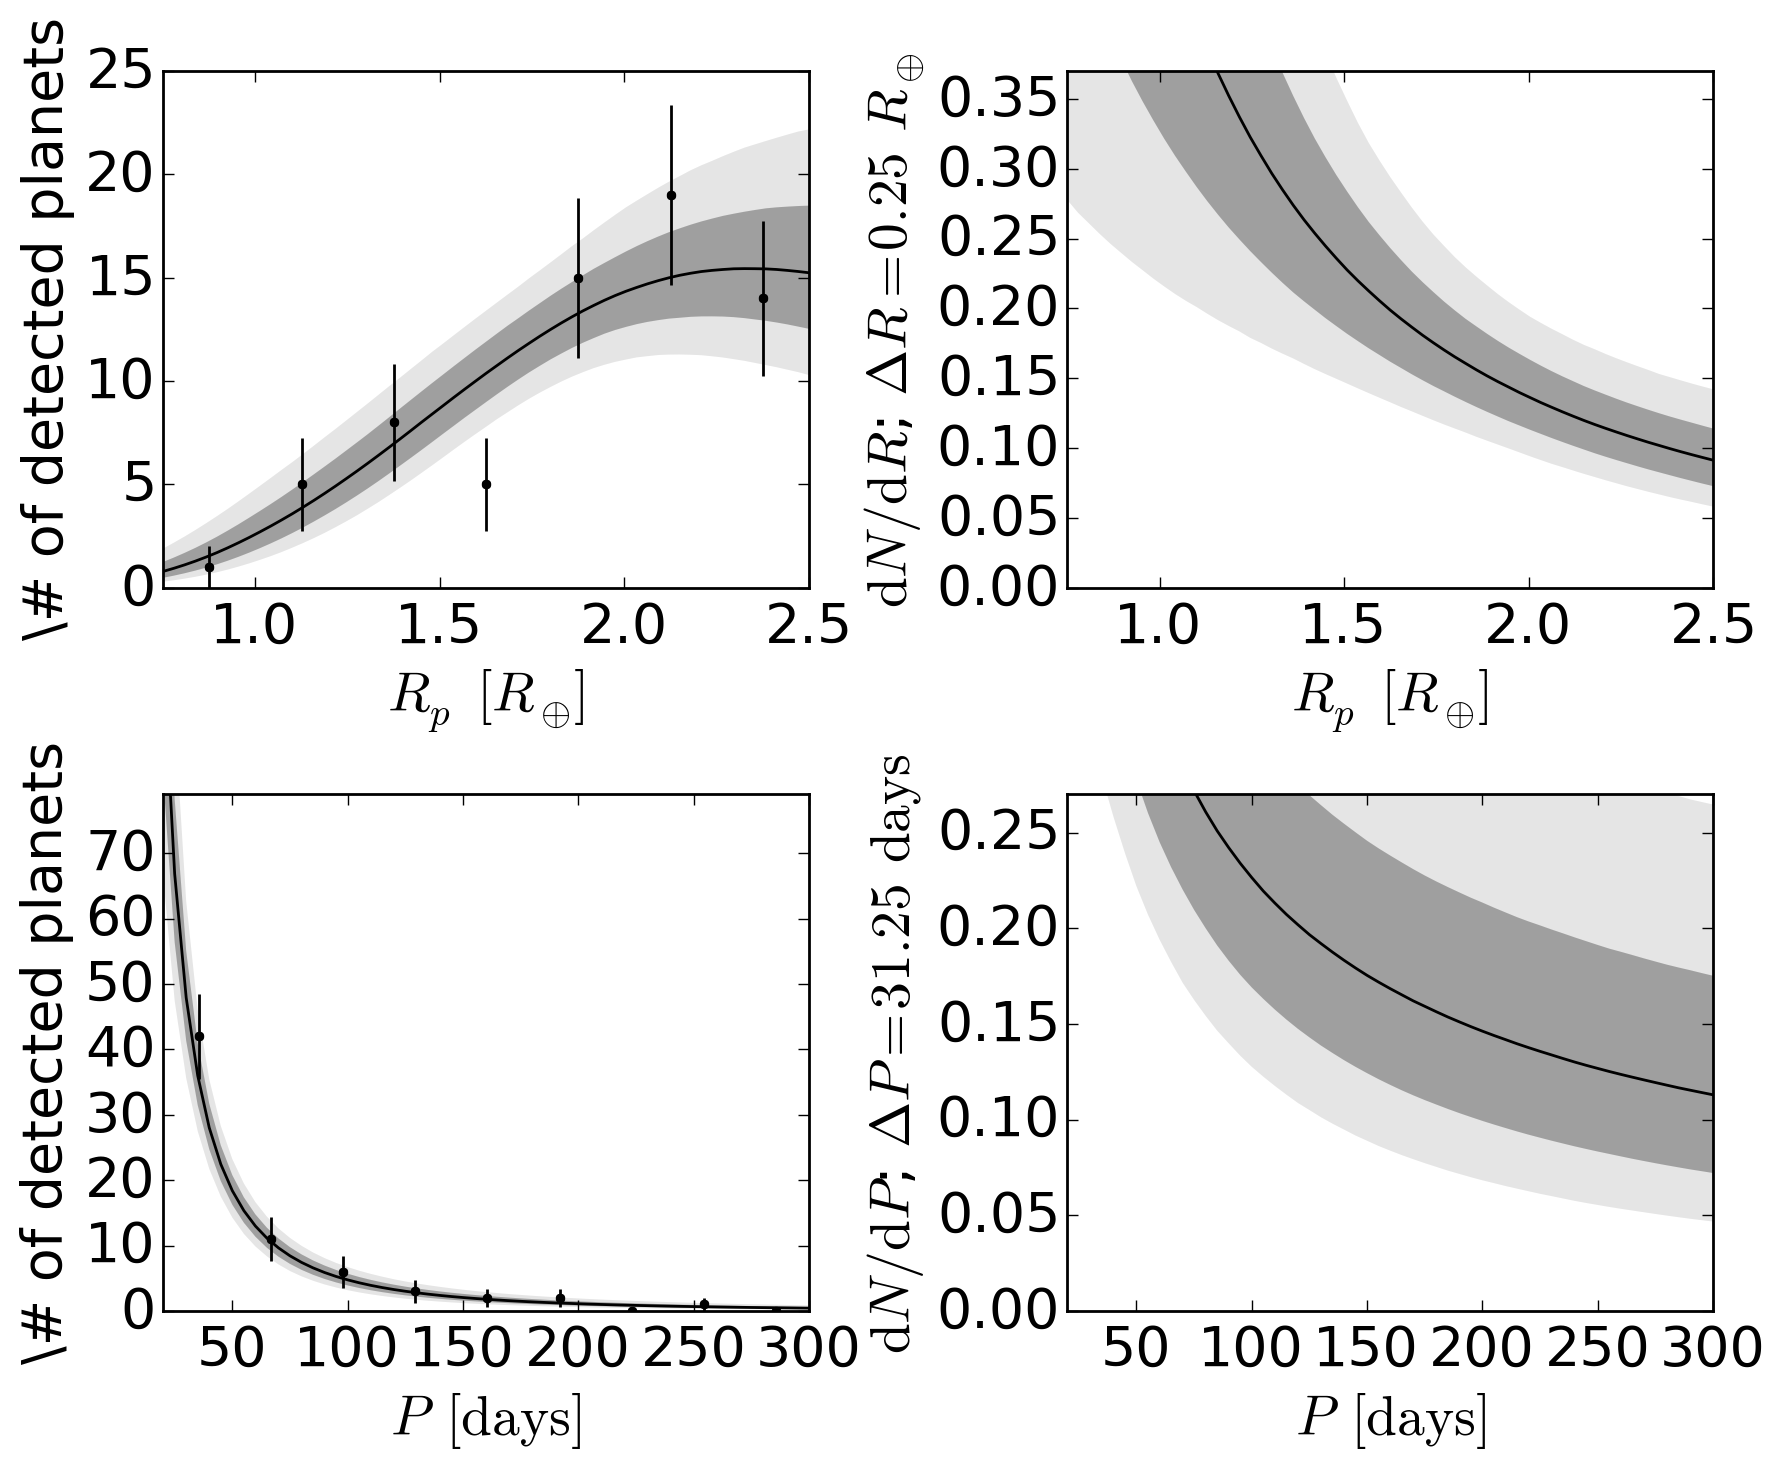

In [116]:
gamma_earth = plot_results(sampler.flatchain)

Comparing this to Figures 6--9 in Burke et al., you'll see that the results are more or less consistent and the predicted observations are good. For radii smaller than $R_\oplus$, the results start to diverge since I chose to use a single power law in radius instead of the double power law. When I tried to use a double power law, I found that the break radius was immediately pushed below $0.95\,R_\oplus$ (the smallest radius in the dataset) and the slope of the smaller radius power law was set only by the prior so it didn't seem necessary to include it here. In practice the final results are still consistent.

I would now claim this as a successful reproduction of the results from Burke et al. using only public datasets and their description of their method. One last interesting plot (that you might have noticed I computed in the `plot_results` function) is Figure 17 showing the rate of Earth-analogs defined (following [my definition](http://arxiv.org/abs/1406.3020)) as:

$$\Gamma_\oplus = \left.\frac{\mathrm{d} N}{\mathrm{d}\ln R_p\,\mathrm{d}\ln P} \right |_\oplus$$

Let's plot the constraint on $\Gamma_\oplus$:

In [20]:
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("the rate of Earth analogs")
pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

NameError: name 'gamma_earth' is not defined

This plot is consistent with Figure 17 from [Burke et al. (2015)](http://arxiv.org/abs/1506.04175) so we'll leave it here and call this a success for open science! Some of you might notice that this result is inconsistent with many previous estimates of this number (including my own!) but the discussion of this discrepancy is a topic for another day (or maybe a scientific publication).

*Thanks to Ruth Angus for reading through and catching some typos!*

In [15]:
def integrated_gamma(theta,period1,period2,radius1,radius2):
    lnf0, beta, alpha = theta
    period_rng = (20, 300)
    radius_rng = (0.75, 2.5)
    v = np.exp(lnf0) * np.ones_like(period)
   
    xx = (period2**(beta+1)-period1**(beta+1))/(period_rng[1]**(beta+1)-period_rng[0]**(beta+1))
    yy = (radius2**(alpha+1) - radius1**(alpha+1))/(radius_rng[1]**(alpha+1) - radius_rng[0]**(alpha+1))
    zz = xx*yy*np.exp(lnf0)
    return zz

In [16]:
int_gamma_samples = np.empty(len(sampler.flatchain))
period1 = 40
period2 = 80
radius1 = 1.5
radius2 = 2.3

for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta, period1,period2,radius1,radius2)
    
    

        
        
# pl.hist(np.log10(gamma_planet), 50, histtype="step", color="k")
# pl.gca().set_yticklabels([])
# pl.title("Integrated ocurrence over radius and period")
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
             

<function matplotlib.pyplot.xticks>

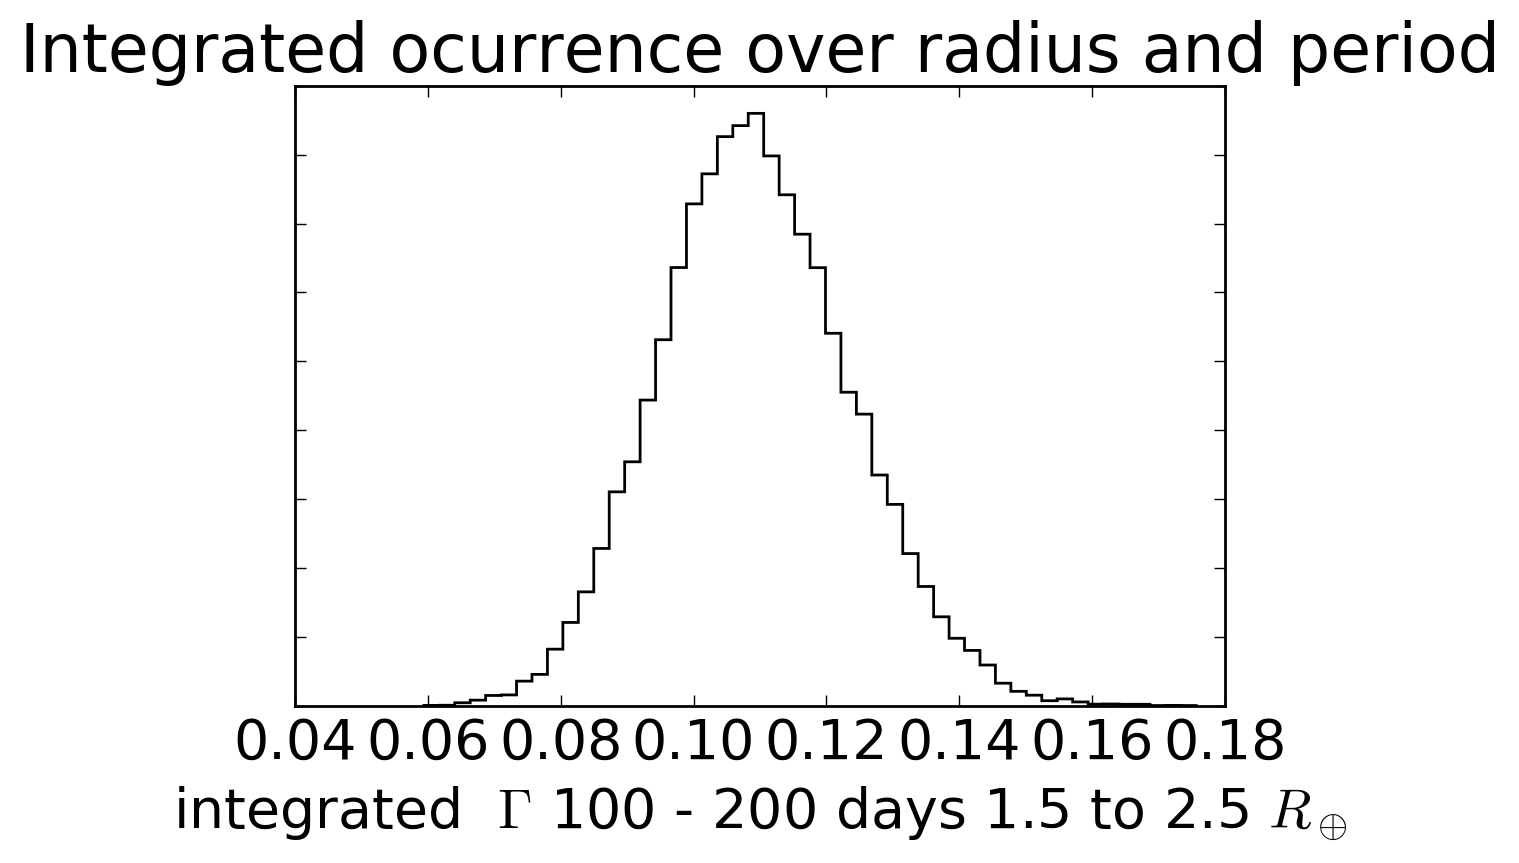

In [17]:
pl.hist(int_gamma_samples, 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Integrated ocurrence over radius and period")
pl.xlabel(r"integrated  $\Gamma$ 100 - 200 days 1.5 to 2.5 $R_\oplus$");
pl.xticks

In [18]:
np.median(int_gamma_samples)

0.10884384005868158

In [19]:
np.percentile(int_gamma_samples,[16,50,84])

array([ 0.0952408 ,  0.10884384,  0.12385903])